## Lorenz system

In [10]:
# Imports
import jax.numpy as jnp
import jax
from diffrax import diffeqsolve, Dopri5, ODETerm, SaveAt, PIDController
jax.config.update('jax_enable_x64',True)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.style.use("default")
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    'font.size': 20
})

In [3]:
# Define constants
s=10
r=28
b=2.667

# Define Lorenz RHS
def lorenz(t,x, args):
    return jnp.array([
        s*(x[1]-x[0]),
        r*x[0] - x[1] - x[0] * x[2],
        x[0]*x[1] - b * x[2]
    ])

In [4]:
# Initial time
t0 = 0.
# Final time
t1 = 10.
# Define the RHS of the system
term = ODETerm(lorenz)
# Pick a solver
solver = Dopri5()
# Save dense output, that can later be evaluated at any point inside [t0,t1]
saveat = SaveAt(dense=True)
# Size control: Adapts the step size to produce a solution accurate to a given tolerance
stepsize_controller = PIDController(rtol=1e-8, atol=1e-8)
# Initial condition
y0 = jnp.array([3.,3.,20])
# Solve
ode_sol = diffeqsolve(
    terms = term, 
    solver = solver, 
    t0=t0, t1=t1, dt0=0.001, 
    y0=y0,
    saveat=saveat,
    stepsize_controller=stepsize_controller,
    max_steps = 5000
    )


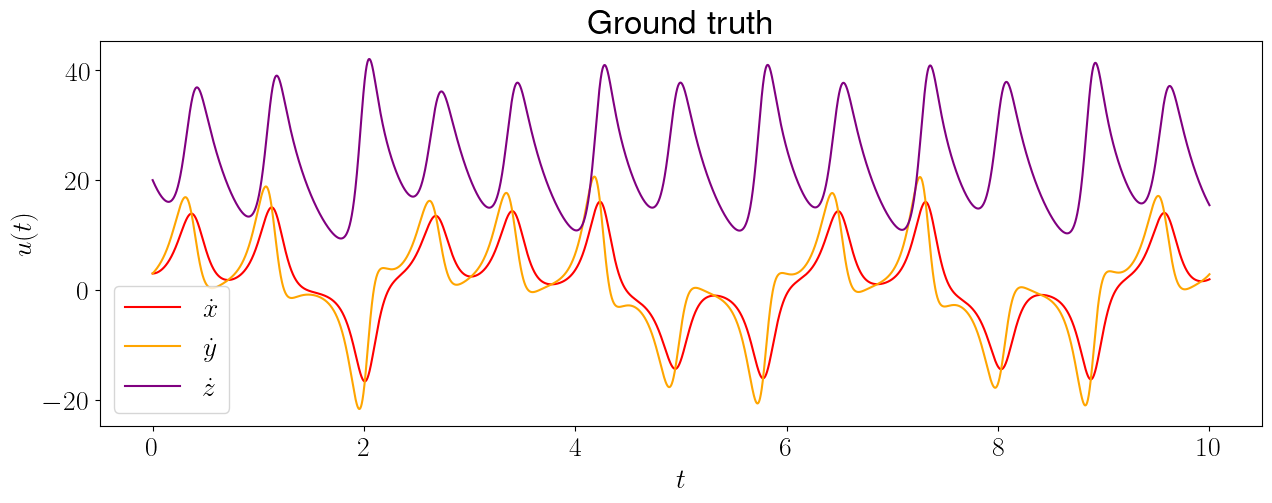

In [9]:
plt.figure(figsize=(15,5))
tvals = jnp.linspace(t0,t1,5000)
y_full = jax.vmap(ode_sol.evaluate)(tvals)
plt.title('Ground truth')
plt.plot(tvals,y_full[:,0], c = 'red', label = r'$\dot x$')
plt.plot(tvals,y_full[:,1], c = 'orange', label = r'$\dot y$')
plt.plot(tvals,y_full[:,2], c = 'purple', label = r'$\dot z$')
# Plot config
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$u(t)$')
plt.show()

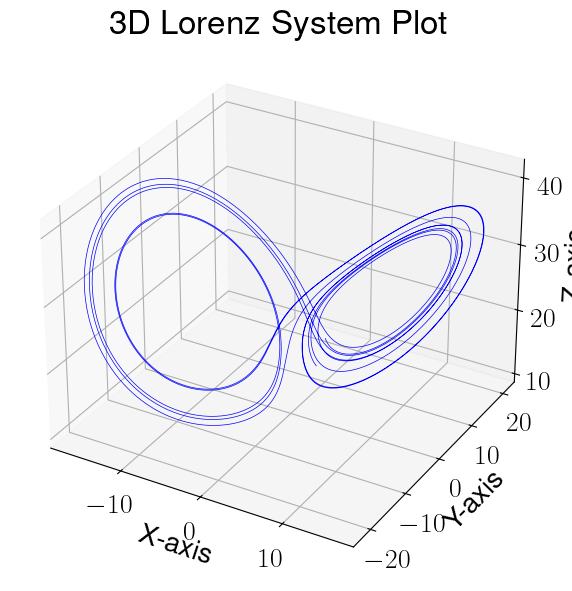

In [13]:
x = y_full[:, 0]
y = y_full[:, 1]
z = y_full[:, 2]

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the Lorenz data
ax.plot(x, y, z, lw=0.5, color='blue')  # Adjust line width and color as needed

# Add labels and a title
ax.set_title("3D Lorenz System Plot")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")

# Show the plot
plt.show()

### Data for problem

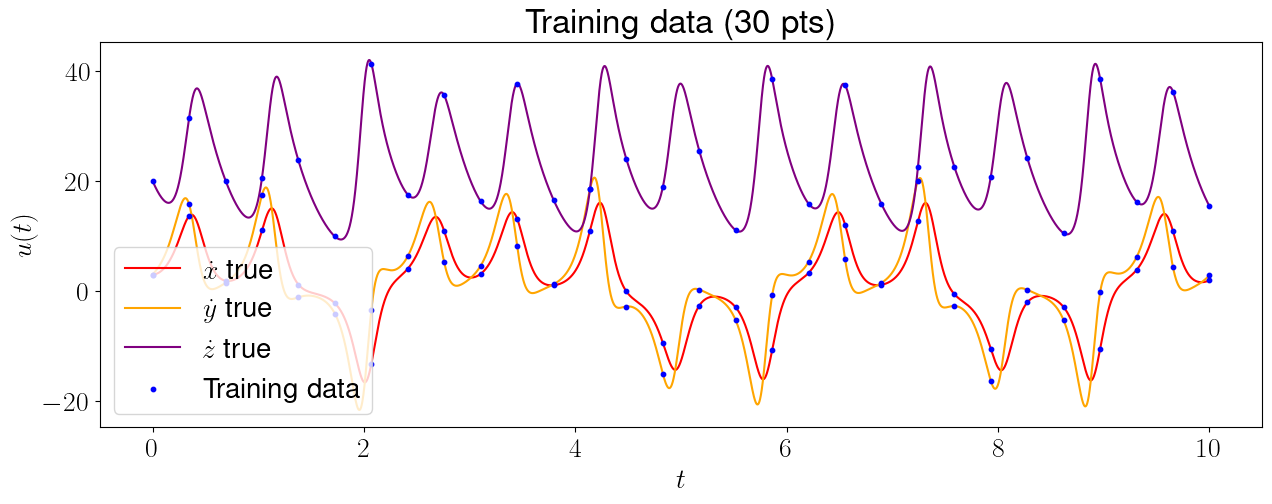

In [25]:
plt.figure(figsize=(15,5))
# X_dense
tvals = jnp.linspace(t0,t1,5000)
# u(X_dense)
y_full = jax.vmap(ode_sol.evaluate)(tvals)
plt.plot(tvals,y_full[:,0], c = 'red', zorder=0, label = r'$\dot x$ true')
plt.plot(tvals,y_full[:,1], c = 'orange', zorder=1, label = r'$\dot y$ true')
plt.plot(tvals,y_full[:,2], c = 'purple', zorder=2, label = r'$\dot z$ true')
# X_obs
# num_obs = 50
# num_obs = 32 # This is the one
num_obs = 30 # Sanity check
obs_times = jnp.linspace(t0,t1,num_obs)
# u(X_obs)
y_obs = jax.vmap(ode_sol.evaluate)(obs_times)
plt.scatter(obs_times,y_obs[:,0], s=10,c= 'blue', zorder=3, label = 'Training data')
plt.scatter(obs_times,y_obs[:,1], s=10,c= 'blue', zorder=4)
plt.scatter(obs_times,y_obs[:,2], s=10,c= 'blue', zorder=5)
plt.title(f'Training data ({num_obs} pts)')
plt.ylabel('$u(t)$')
plt.xlabel('$t$')
plt.legend(loc = 'lower left')
plt.show()

In [26]:
t_obs = obs_times.reshape(-1,1)

In [ ]:
from Kernels import (
    get_centered_scaled_poly_kernel,
    get_anisotropic_gaussianRBF,
    fit_kernel_params,
    get_gaussianRBF,
    get_rq_kernel
)
from EquationModel import CholInducedRKHS, CholOperatorModel, OperatorPDEModel,InducedOperatorModel
from functools import partial
from Kernels import log1pexp,inv_log1pexp

def dtt_k(k,index = 0):
    return dt_k(dt_k(k,index),index)

u_operators = (eval_k,dt_k,dtt_k)

feature_operators = (eval_k,dt_k)

k_u = get_rq_kernel(1.)
num_colloc = 1000
t_grid = jnp.linspace(t0,t1,num_colloc).reshape(-1,1)


u_model = CholInducedRKHS(
    t_grid,
    u_operators,
    k_u,
    nugget_size = 1e-8
    )

u_params_init = u_model.get_fitted_params(t_obs,y_obs)

grid_features_init = (
    (u_model.evaluate_operators(feature_operators,t_grid,u_params_init))
    .reshape(
            len(t_grid),
            len(feature_operators),
            order = 'F'
        )
)
grid_features_init = jnp.hstack([t_grid,grid_features_init])

num_P_inducing = 500
P_inducing_points = jax.random.choice(jax.random.PRNGKey(13),grid_features_init,(num_P_inducing,))

k_P_u_part = get_gaussianRBF(1.)
def k_P(x,y):
    return k_P_u_part(x[1:],y[1:])
P_model = InducedOperatorModel(P_inducing_points,k_P)

EqnModel = OperatorPDEModel(
    P_model,
    (u_model,),
    (t_obs,),
    (y_obs,),
    (t_grid,),
    feature_operators,
    rhs_operator=dtt_k,
    datafit_weight = 50,
    rhs_forcing_values = (-forcing(t_grid)[:,0],),
    num_P_operator_params = 500
)

utt_init = EqnModel.apply_rhs_op_single(u_model,u_params_init,EqnModel.collocation_points[0])-forcing(t_grid)[:,0]
P_params_init = P_model.get_fitted_params(grid_features_init,utt_init,lam = 1e-3)
params_init = jnp.hstack([u_params_init,P_params_init])